### Model using New Data

In [71]:
import numpy as np
import pandas as pd
from IPython.display import Markdown, display

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import diverging_palette

import sklearn
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.semi_supervised import LabelPropagation, LabelSpreading

from sklearn.linear_model import (
    LogisticRegression,
    Lasso
)

from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier
)

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_val_predict,
    RepeatedStratifiedKFold,
    GridSearchCV,
    KFold
)

from sklearn.metrics import (
    accuracy_score, 
    precision_score, average_precision_score,
    precision_recall_curve,
    confusion_matrix, plot_confusion_matrix,
    roc_curve, roc_auc_score,
    classification_report
)

import lightgbm as lgb
from lightgbm import LGBMClassifier, plot_importance

from yellowbrick.classifier import (
    ConfusionMatrix,
    ROCAUC
)

import warnings
from warnings import simplefilter
warnings.filterwarnings("ignore")
simplefilter("ignore", category=ConvergenceWarning)

pd.set_option('display.max_columns', None) # Show all the columns

In [72]:
url = 'https://raw.githubusercontent.com/McGill-MMA-EnterpriseAnalytics/Airline-Passenger-Satisfaction-Prediction-Part2/Dev/Data/df6.csv'
data = pd.read_csv(url)
data

,id,Age,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,Food_and_drink,Online_boarding,Seat_comfort,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,satisfaction,Gender_Male,Customer_Type_Loyal Customer,Type_of_Travel_Business travel
0,110028.0,26.0,0.0,1142.0,2.0,2.0,2.0,2.0,5.0,5.0,5.0,5.0,4.0,3.0,4.0,4.0,4.0,5.0,0.0,1.0,0.0,1.0,1.0
1,119299.0,61.0,0.0,214.0,3.0,3.0,3.0,3.0,4.0,5.0,5.0,3.0,3.0,4.0,4.0,3.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0
2,82113.0,47.0,2.0,1276.0,2.0,4.0,2.0,3.0,2.0,2.0,2.0,2.0,3.0,3.0,4.0,3.0,5.0,2.0,9.0,0.0,1.0,1.0,0.0
3,96462.0,52.0,0.0,2035.0,4.0,3.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,1.0,0.0,1.0,1.0
4,65725.0,20.0,2.0,1061.0,3.0,3.0,3.0,4.0,2.0,3.0,3.0,2.0,2.0,3.0,4.0,4.0,3.0,2.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42897,86549.0,26.0,0.0,712.0,4.0,4.0,4.0,4.0,5.0,5.0,5.0,5.0,3.0,4.0,4.0,3.0,4.0,5.0,17.0,1.0,1.0,1.0,1.0
42898,102203.0,60.0,0.0,1599.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,9.0,1.0,0.0,1.0,1.0
42899,60666.0,50.0,2.0,1620.0,3.0,1.0,3.0,4.0,2.0,3.0,2.0,2.0,4.0,3.0,4.0,2.0,4.0,2.0,0.0,0.0,1.0,1.0,0.0
42900,94171.0,23.0,2.0,192.0,2.0,1.0,2.0,3.0,2.0,2.0,2.0,2.0,3.0,1.0,4.0,2.0,3.0,2.0,3.0,0.0,0.0,0.0,1.0


# Data Preparation

## Standardization of Numeric Variables

In [73]:
numeric_cols = ['Age', 'Flight_Distance','Departure_Delay_in_Minutes']
scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

## Handling Missing Values

The satisfaction level of each feature should range from 1 to 5.

If the rating is 0, that means the customer did not rate for this feature.

In [74]:
def list_column_values(df, number_of_values, print_all):
    display(Markdown('**Results:**' ))
    for col in df.columns[0:]:
        if df[col].nunique() <= number_of_values:
            print(f"{col.ljust(25)}" +  ' ==> ' + str(df[col].sort_values().unique().tolist()) )
        else:  
            if print_all=='True':
               
                print(f"{col.ljust(25)}" + ' ==> more than ' + str(number_of_values) + ' values')

list_column_values(data, data.shape[1],'True')

**Results:**

id                        ==> more than 23 values
Age                       ==> more than 23 values
Class                     ==> [0.0, 1.0, 2.0]
Flight_Distance           ==> more than 23 values
Inflight_wifi_service     ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Departure/Arrival_time_convenient ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Ease_of_Online_booking    ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Gate_location             ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Food_and_drink            ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Online_boarding           ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Seat_comfort              ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Inflight_entertainment    ==> [1.0, 2.0, 3.0, 4.0, 5.0]
On-board_service          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Leg_room_service          ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Baggage_handling          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Checkin_service           ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Inflight_service          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Cleanliness               ==> [1.0, 2.0, 3.

In [75]:
incomplete = ['Inflight_wifi_service','Departure/Arrival_time_convenient',
              'Ease_of_Online_booking','Online_boarding','Leg_room_service']
(data[incomplete] == 0).sum()

Inflight_wifi_service                162
Departure/Arrival_time_convenient    276
Ease_of_Online_booking               145
Online_boarding                        9
Leg_room_service                       3
dtype: int64

#### We should consider rating=0 as missing values as the customer did not provide any rating feedback.

In [76]:
(data[incomplete] == 0).sum().sum()/data.shape[0]

0.013868817304554566

#### Missing ratings only takes up 1.3% of the dataset, try advanced imputation techniques here

## KNN Imputation

In [77]:
#replace the 0 value as nan
data[incomplete] = data[incomplete].replace(0, np.nan)

In [78]:
data[incomplete].isnull().sum()

Inflight_wifi_service                162
Departure/Arrival_time_convenient    276
Ease_of_Online_booking               145
Online_boarding                        9
Leg_room_service                       3
dtype: int64

In [79]:
null_rows_idx = data.isnull().any(axis=1)

data.loc[null_rows_idx].head(3)

,id,Age,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,Food_and_drink,Online_boarding,Seat_comfort,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,satisfaction,Gender_Male,Customer_Type_Loyal Customer,Type_of_Travel_Business travel
14,14849.0,-0.056376,0.0,-1.041118,NaN,NaN,NaN,3.0,2.0,5.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,-0.454514,1.0,1.0,1.0,1.0
66,85554.0,0.545156,0.0,-1.020660,NaN,1.0,1.0,1.0,3.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,5.0,-0.454514,1.0,0.0,1.0,1.0
342,48727.0,0.620348,0.0,2.036342,NaN,5.0,NaN,4.0,2.0,5.0,5.0,4.0,4.0,4.0,4.0,3.0,4.0,3.0,-0.454514,1.0,0.0,1.0,1.0


In [80]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)

data_num = data.select_dtypes(include=[np.number])
imputer.fit(data_num)

X_ = imputer.transform(data_num)

#save in df4_knn
data_knn = pd.DataFrame(X_, columns=data_num.columns, index=data_num.index)

data_knn.loc[null_rows_idx].head(3)

,id,Age,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,Food_and_drink,Online_boarding,Seat_comfort,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,satisfaction,Gender_Male,Customer_Type_Loyal Customer,Type_of_Travel_Business travel
14,14849.0,-0.056376,0.0,-1.041118,3.6,3.6,2.8,3.0,2.0,5.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,-0.454514,1.0,1.0,1.0,1.0
66,85554.0,0.545156,0.0,-1.020660,3.4,1.0,1.0,1.0,3.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,5.0,-0.454514,1.0,0.0,1.0,1.0
342,48727.0,0.620348,0.0,2.036342,3.0,5.0,3.0,4.0,2.0,5.0,5.0,4.0,4.0,4.0,4.0,3.0,4.0,3.0,-0.454514,1.0,0.0,1.0,1.0


#### Since the satisfaction level can only be 1,2,3,4, or 5. we need to conver the value to integer

In [81]:
import math

def ceil(x):
    return math.ceil(x - 0.5)

data_knn[incomplete] = data_knn[incomplete].applymap(ceil)

data_knn.loc[null_rows_idx].head(3)

,id,Age,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,Food_and_drink,Online_boarding,Seat_comfort,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,satisfaction,Gender_Male,Customer_Type_Loyal Customer,Type_of_Travel_Business travel
14,14849.0,-0.056376,0.0,-1.041118,4,4,3,3.0,2.0,5,3.0,4.0,4.0,4,4.0,4.0,4.0,3.0,-0.454514,1.0,1.0,1.0,1.0
66,85554.0,0.545156,0.0,-1.020660,3,1,1,1.0,3.0,4,5.0,4.0,4.0,4,4.0,4.0,4.0,5.0,-0.454514,1.0,0.0,1.0,1.0
342,48727.0,0.620348,0.0,2.036342,3,5,3,4.0,2.0,5,5.0,4.0,4.0,4,4.0,3.0,4.0,3.0,-0.454514,1.0,0.0,1.0,1.0


In [82]:
list_column_values(data_knn, data_knn.shape[1],'True')

**Results:**

id                        ==> more than 23 values
Age                       ==> more than 23 values
Class                     ==> [0.0, 1.0, 2.0]
Flight_Distance           ==> more than 23 values
Inflight_wifi_service     ==> [1, 2, 3, 4, 5]
Departure/Arrival_time_convenient ==> [1, 2, 3, 4, 5]
Ease_of_Online_booking    ==> [1, 2, 3, 4, 5]
Gate_location             ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Food_and_drink            ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Online_boarding           ==> [1, 2, 3, 4, 5]
Seat_comfort              ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Inflight_entertainment    ==> [1.0, 2.0, 3.0, 4.0, 5.0]
On-board_service          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Leg_room_service          ==> [1, 2, 3, 4, 5]
Baggage_handling          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Checkin_service           ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Inflight_service          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Cleanliness               ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Departure_Delay_in_Minutes ==> more than 23 values
satisfactio

## Splitting the Dataset

In [83]:
# Identify features and target
X = data_knn.drop(columns=['satisfaction'])
y = data_knn['satisfaction']

### Train Test Split

In [84]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.2, random_state = 777)

N_train, _ = X_train.shape 
N_val_test,  _ = X_val_test.shape 

N_train, N_val_test

(34321, 8581)

### Test Validation Split

In [85]:
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5, random_state = 777)

N_val, _ = X_val.shape 
N_test,  _ = X_test.shape 

N_val, N_test

(4290, 4291)

In [86]:
data_knn.columns

Index(['id', 'Age', 'Class', 'Flight_Distance', 'Inflight_wifi_service',
       'Departure/Arrival_time_convenient', 'Ease_of_Online_booking',
       'Gate_location', 'Food_and_drink', 'Online_boarding', 'Seat_comfort',
       'Inflight_entertainment', 'On-board_service', 'Leg_room_service',
       'Baggage_handling', 'Checkin_service', 'Inflight_service',
       'Cleanliness', 'Departure_Delay_in_Minutes', 'satisfaction',
       'Gender_Male', 'Customer_Type_Loyal Customer',
       'Type_of_Travel_Business travel'],
      dtype='object')

# Functions for Evaluation Metrics

### ROC Curve

In [87]:
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### PR Curve

In [88]:
def plot_pr_curve(precision, recall, average_precision):
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')   
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

### Classification Score

It gets the model and evaluates it for training and validation.

In [89]:
def clf_score(clf, X_train, y_train, X_val, y_val, train=True):
    if train:
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))

    elif train == False:
        print("Validation Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_val, clf.predict(X_val))))
        
        precision, recall, _ = precision_recall_curve(y_val, clf.predict(X_val))
        average_precision = average_precision_score(y_val, clf.predict(X_val))
        plot_pr_curve(precision, recall, average_precision)
        
        fpr, tpr, _ = roc_curve(y_val, clf.predict(X_val))
        roc_auc = roc_auc_score(y_val, clf.predict(X_val))
        print("roc auc score: {}\n".format(roc_auc))
        plot_roc_curve(fpr, tpr, roc_auc)
        
        print("Classification Report: \n {}\n".format(classification_report(y_val, clf.predict(X_val))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_val, clf.predict(X_val))))
        plot_confusion_matrix(clf,  X_val, clf.predict(X_val))
        print("End of validation Result\n")

### Model Results Comparison

In [90]:
model_comparison = pd.DataFrame(columns=['precision','recall','f1-score','support'])

def add_result(model_name, y_actual, y_pred):
    global model_comparison

    report = classification_report(y_actual, y_pred, output_dict=True)
    scores = pd.DataFrame(report['1.0'],index=[model_name])

    model_comparison = model_comparison.append(scores)
    
    print(model_comparison)

In [91]:
X_train = X_train.drop(columns=['Gender_Male', 'Gate_location', 'Food_and_drink', 'Age'])
X_val = X_val.drop(columns=['Gender_Male', 'Gate_location', 'Food_and_drink', 'Age'])

## The H2O- Auto ML

#### In the other file we did a aH2O Auto ML test, Model Summary show as below: 
Gradient Boosting Machine 

number_of_trees = 78    
number_of_internal_trees=78   
model_size_in_bytes=216621    
min_depth = 10  
max_depth = 10  
mean_depth= 10   
min_leaves=100   
max_leaves    = 344 
mean_leaves = 216.564


In [92]:
from sklearn.ensemble import GradientBoostingClassifier

In [93]:
gbm_clf = GradientBoostingClassifier(#number_of_trees = 78,
                                     #number_of_internal_trees=78,
                                     #model_size_in_bytes=216621,
                                     #min_depth = 10,
                                     max_depth = 10,
                                     #mean_depth= 10,
                                     #min_leaves=100,
                                     #max_leaves    = 344
                                     #mean_leaves = 216.564
)
    


In [94]:
model_gbm= gbm_clf.fit(X_train, y_train)

Validation Result:

accuracy score: 0.9783



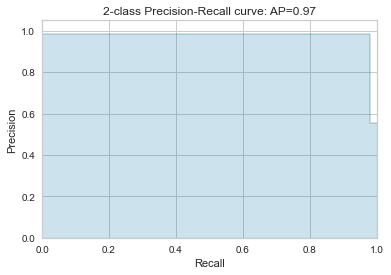

roc auc score: 0.9783476707434382



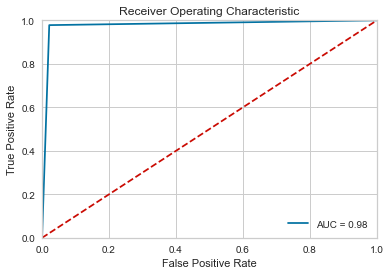

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.97      0.98      0.98      1915
         1.0       0.98      0.98      0.98      2375

    accuracy                           0.98      4290
   macro avg       0.98      0.98      0.98      4290
weighted avg       0.98      0.98      0.98      4290


Confusion Matrix: 
 [[1874   41]
 [  52 2323]]

End of validation Result



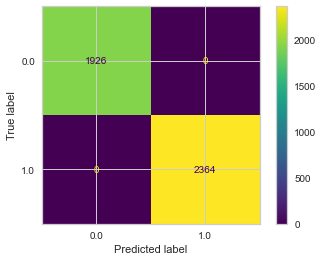

In [95]:
clf_score(model_gbm, X_train, y_train, X_val, y_val, train=False)

In [96]:
# Add result to model_comparison dataframe
model_name = 'GBM'
y_pred = model_gbm.predict(X_val)

add_result(model_name, y_val, y_pred)

     precision    recall  f1-score support
GBM   0.982657  0.978105  0.980376    2375


#### Validation Curve

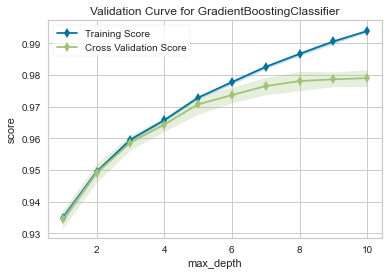

<AxesSubplot:title={'center':'Validation Curve for GradientBoostingClassifier'}, xlabel='max_depth', ylabel='score'>

In [97]:
from yellowbrick.model_selection import ValidationCurve

viz = ValidationCurve(
    GradientBoostingClassifier(n_estimators=40, random_state=42), 
    param_name="max_depth",
    param_range=np.arange(1, 11), 
    cv=5, 
    scoring="f1_weighted",
    np_jobs=8
)

# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.poof()

In [98]:
X_train_small = X_train.iloc[:200,]
y_train_small = y_train.iloc[:200]

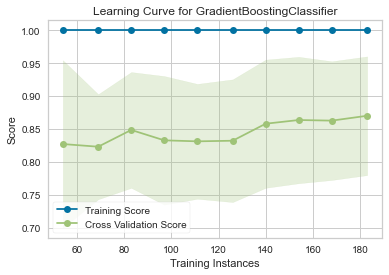

<AxesSubplot:title={'center':'Learning Curve for GradientBoostingClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [99]:
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import LearningCurve

import numpy as np


# Create the learning curve visualizer
cv = StratifiedKFold(n_splits=12)
sizes = np.linspace(0.3, 1.0, 10)

# Instantiate the classification model and visualizer

visualizer = LearningCurve(
    model_gbm, 
    cv=cv, 
    scoring='f1_weighted', 
    train_sizes=sizes, 
    n_jobs=8
)

visualizer.fit(X_train_small, y_train_small)        # Fit the data to the visualizer
visualizer.poof() 

### It will be overfitting

### Test TPOT Model result

Best pipeline: ExtraTreesClassifier(PolynomialFeatures(MinMaxScaler(input_matrix), degree=2, include_bias=False, interaction_only=False), bootstrap=False, criterion=entropy, max_features=0.6000000000000001, min_samples_leaf=3, min_samples_split=13, n_estimators=100)

In [100]:
from sklearn.ensemble import ExtraTreesClassifier

tree_clf = ExtraTreesClassifier(#PolynomialFeatures(MinMaxScaler(input_matrix), 
                                                     #degree=2, 
                                                     #include_bias=False, 
                                                     #interaction_only=False), 
                                  bootstrap=False, 
                                  criterion='entropy',
                                  max_features=0.6000000000000001, 
                                  min_samples_leaf=3, 
                                  min_samples_split=13,
                                  n_estimators=100)

Validation Result:

accuracy score: 0.9804



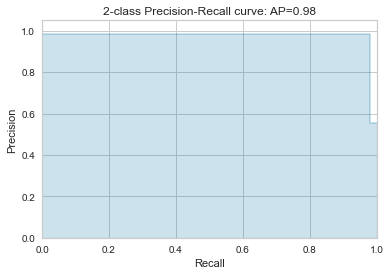

roc auc score: 0.9804446887453621



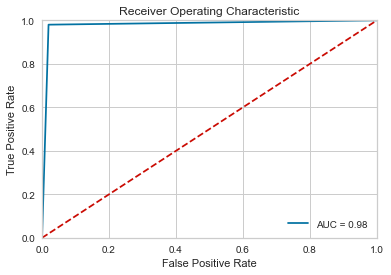

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      1915
         1.0       0.98      0.98      0.98      2375

    accuracy                           0.98      4290
   macro avg       0.98      0.98      0.98      4290
weighted avg       0.98      0.98      0.98      4290


Confusion Matrix: 
 [[1878   37]
 [  47 2328]]

End of validation Result



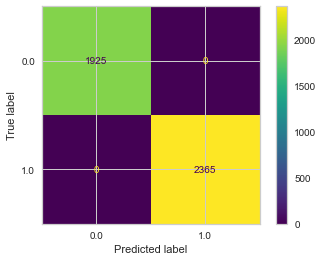

In [101]:
model_tree = tree_clf.fit(X_train,y_train)

clf_score(model_tree, X_train, y_train, X_val, y_val, train=False)

In [102]:
# Add result to model_comparison dataframe
model_name = 'ExtraTree'
y_pred = model_tree.predict(X_val)

add_result(model_name, y_val, y_pred)

           precision    recall  f1-score support
GBM         0.982657  0.978105  0.980376    2375
ExtraTree   0.984355  0.980211  0.982278    2375


#### Validation Curve

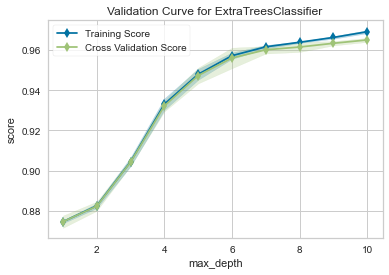

<AxesSubplot:title={'center':'Validation Curve for ExtraTreesClassifier'}, xlabel='max_depth', ylabel='score'>

In [103]:
from yellowbrick.model_selection import ValidationCurve

viz = ValidationCurve(
    ExtraTreesClassifier(n_estimators=40, random_state=42), 
    param_name="max_depth",
    param_range=np.arange(1, 11), 
    cv=5, 
    scoring="f1_weighted",
    np_jobs=8
)

# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.poof()

In [104]:
X_train_small = X_train.iloc[:2000,]
y_train_small = y_train.iloc[:2000]

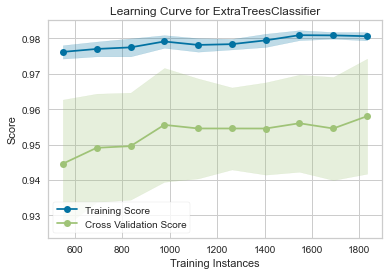

<AxesSubplot:title={'center':'Learning Curve for ExtraTreesClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [105]:
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import LearningCurve

import numpy as np


# Create the learning curve visualizer
cv = StratifiedKFold(n_splits=12)
sizes = np.linspace(0.3, 1.0, 10)

# Instantiate the classification model and visualizer

visualizer = LearningCurve(
    model_tree, 
    cv=cv, 
    scoring='f1_weighted', 
    train_sizes=sizes, 
    n_jobs=8
)

visualizer.fit(X_train_small, y_train_small)        # Fit the data to the visualizer
visualizer.poof() 

# Evaluate model on test set

Given the results, LightGBM has the highest F1-Score. Now we test the model performance on the unseen test dataset.

In [106]:
print('before:', X_test.shape)
X_test = X_test.drop(columns=['Gender_Male', 'Gate_location', 'Food_and_drink', 'Age'])
print('after', X_test.shape)

before: (4291, 22)
after (4291, 18)


In [107]:
best_model = model_tree

#### Class Predictor Error

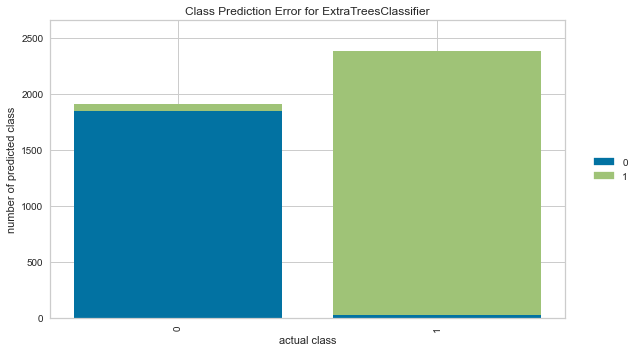

<AxesSubplot:title={'center':'Class Prediction Error for ExtraTreesClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [108]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,5)

from yellowbrick.classifier import ClassPredictionError

classes = ["0", "1"]

visualizer = ClassPredictionError(
    best_model, classes=classes, is_fitted=True
)

# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
visualizer.show()

#### Classification Report

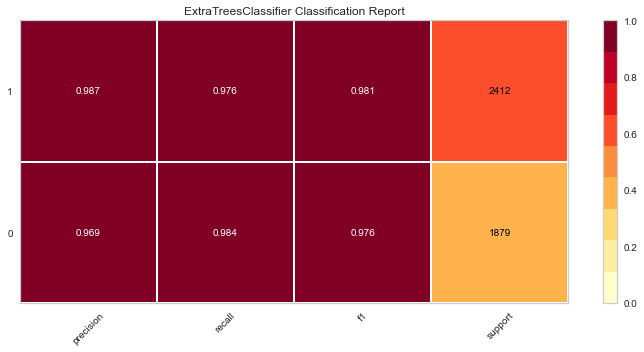

<AxesSubplot:title={'center':'ExtraTreesClassifier Classification Report'}>

In [109]:
from yellowbrick.classifier import ClassificationReport

visualizer = ClassificationReport(
    best_model, classes=classes, support=True, is_fitted=True
)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

#### Confusion Matrix

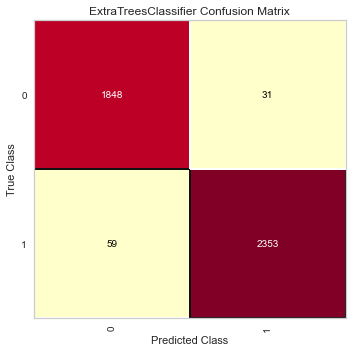

<AxesSubplot:title={'center':'ExtraTreesClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [110]:
from yellowbrick.classifier import confusion_matrix, ConfusionMatrix
matplotlib.rcParams['figure.figsize'] = (5,5)

# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(best_model, classes=[0,1], is_fitted=True)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.show()

#### PR Curve

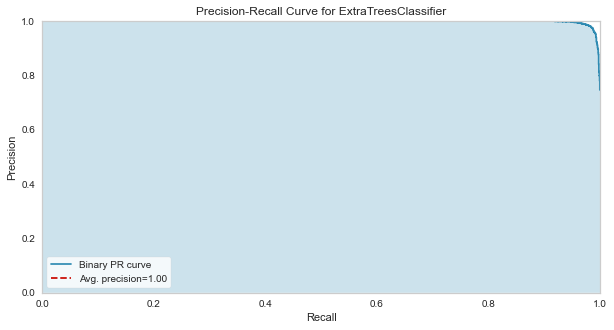

<AxesSubplot:title={'center':'Precision-Recall Curve for ExtraTreesClassifier'}, xlabel='Recall', ylabel='Precision'>

In [111]:
from yellowbrick.classifier import PrecisionRecallCurve
matplotlib.rcParams['figure.figsize'] = (10,5)

# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(best_model, is_fitted=True)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

#### ROC-AUC

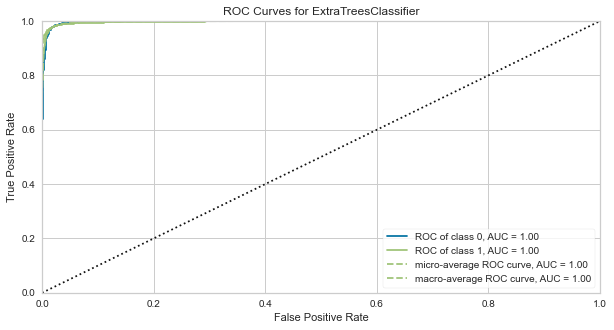

<AxesSubplot:title={'center':'ROC Curves for ExtraTreesClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [112]:
visualizer = ROCAUC(
    best_model, classes=classes, is_fitted=True
)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure